In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class PrintLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_name):
        super(PrintLayerOutputCallback, self).__init__()
        self.layer_name = layer_name

    def on_batch_end(self, batch, logs=None):
        layer_output = self.model.get_layer(self.layer_name).output
        intermediate_model = Model(inputs=self.model.input, outputs=layer_output)
        output = intermediate_model.predict(self.validation_data[0])
        print(f"Output of layer {self.layer_name} after batch {batch + 1}: {output}")

print_output_callback = PrintLayerOutputCallback(layer_name='h2_layer')  # Assuming 'h2' is the name of your layer


class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)


In [4]:

# # Step 1: Generate the Data
# np.random.seed(42)
# n_samples = 10000
# lower_bound = -1
# upper_bound = 1

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 2))
# y = 3 * np.cos(2 * np.pi * (X[:, 0]**2 - X[:, 1]**2)).reshape(-1, 1)

# # Step 2: Split the Data
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Display the shapes of the datasets
# print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

# # Step 3: Update the Model
# def build_model(input_shape, filters):
#     rank = 3
#     input_layer = Input(shape=input_shape)
#     x = input_layer

#     h1 = H1Layer()
#     h2 = H2Layer(h1)
#     h3 = H3Layer(h1,h2)
#     h4 = H4Layer(h2,h3)
#     h5 = H5Layer(h3,h4)

#     x = Dense(filters)(x)
#     x = h2(x)
#     x = Dense(filters)(x)
#     x = TensorDecompositionLayer(rank)(x)
#     x = h3(x)
#     x = Dense(filters)(x)
#     x = TensorDecompositionLayer(rank)(x)
#     x = h4(x)
#     x = Dense(filters)(x)
#     x = TensorDecompositionLayer(rank)(x)
    
#     output_layer = Dense(1)(x)
#     model = Model(inputs=input_layer, outputs=output_layer)

#     return model 

# input_shape = (2,)
# filters = 128
# model = build_model(input_shape, filters)
# model.summary()

# # Step 3: Train the Model
# optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss='mse')

# batch_size = 128
# epochs = 150

# history = model.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks = [])

# # Step 4: Evaluate the Model
# val_loss = model.evaluate(X_val, y_val, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)
# print(f"Validation loss: {val_loss}")
# print(f"Test loss: {test_loss}")

# # Visualizing the Model's Predictions
# # 1. Generate a grid of (x, y) values
# x = np.linspace(lower_bound, upper_bound, 100)
# y = np.linspace(lower_bound, upper_bound, 100)
# X, Y = np.meshgrid(x, y)
# Z = np.c_[X.ravel(), Y.ravel()]

# # 2. Compute the true function values
# true_values = np.cos(Z[:, 0]) + np.sin(Z[:, 1])


# # 3. Compute the model predictions
# predictions = model.predict(Z).ravel()

# # 4. Create a 3D plot
# fig = plt.figure(figsize=(12, 6))

# # Plot true values
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.plot_surface(X, Y, true_values.reshape(X.shape), cmap='viridis', alpha=0.8)
# ax1.set_title('True Function Values')

# # Plot model predictions
# ax2 = fig.add_subplot(122, projection='3d')
# ax2.plot_surface(X, Y, predictions.reshape(X.shape), cmap='viridis', alpha=0.8)
# ax2.set_title('Model Predictions')

# plt.show()


(7000,) (1500,) (1500,) (7000,) (1500,) (1500,)
Epoch 1/100
219/219 [==============================] - 3s 3ms/step - loss: 1.4227 - val_loss: 0.2108
Epoch 2/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0363 - val_loss: 0.0097
Epoch 3/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 4/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 5/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 6/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 7/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0065
Epoch 8/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0153
Epoch 9/100
219/219 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 10/100
219/219 [=====================

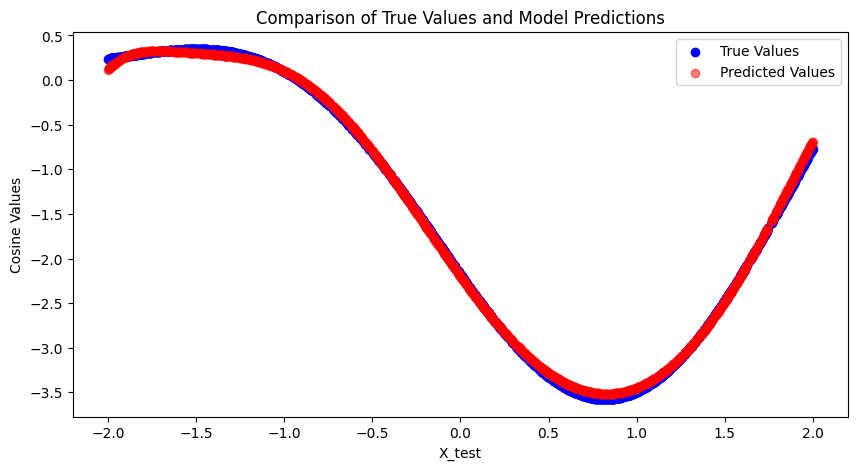

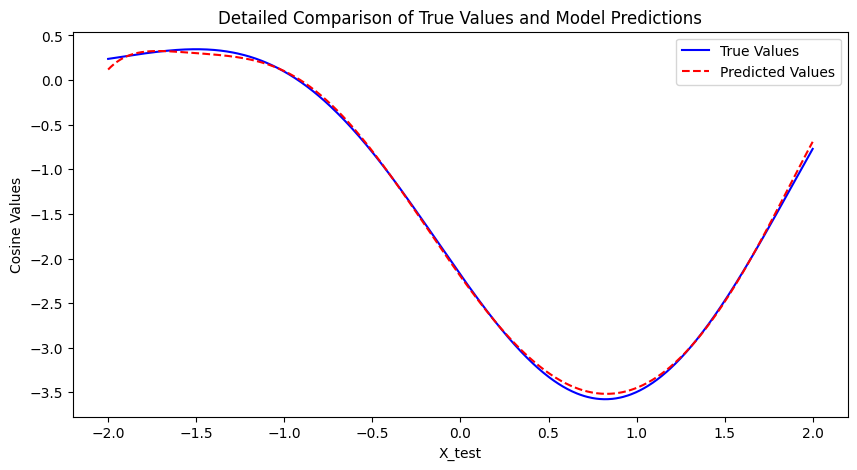

In [3]:

# Step 1: Generate the Data
# np.random.seed(42)
# n_samples = 10000
# lower_bound = -10  # Adjusted lower bound
# upper_bound = 10   # Adjusted upper bound

# X = np.random.uniform(lower_bound, upper_bound, size=n_samples)
# y = np.cos(np.sin(X))  # Compute the cosine of X

import numpy as np

def complex_wave(x):
    # Create a complex wave by summing sine and cosine waves with random frequencies and phases
    wave = np.zeros_like(x)
    num_components = 5  # The number of sine/cosine components to add
    for _ in range(num_components):
        frequency = np.random.uniform(0.5, 2.0)  # Random frequency
        phase = np.random.uniform(0, 2*np.pi)  # Random phase
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        wave += amplitude * np.sin(frequency * x + phase) + amplitude * np.cos(frequency * x + phase)
    return wave

# Generate a wave over a range of points
X = np.linspace(-2, 2, 10000)
y = complex_wave(X)

# Step 2: Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the datasets
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Step 3: Update the Model
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Build the model
model = build_model(input_shape=(1,), filters=10)  # 'filters' is the number of neurons in Dense layers, adjust as needed

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train.reshape(-1, 1),  # Reshape X_train to be a 2D array as expected by the model
    y_train,
    validation_data=(X_val.reshape(-1, 1), y_val),  # Reshape X_val to be a 2D array
    epochs=100,  # Set the number of epochs
    batch_size=32,  # Set the batch size
    callbacks=[callback]
)

import matplotlib.pyplot as plt

# Predict the model output on the test dataset
y_pred = model.predict(X_test.reshape(-1, 1))

# Scatter plot to compare the true values against the predicted values
plt.figure(figsize=(10, 5))

# True values
plt.scatter(X_test, y_test, color='blue', label='True Values')

# Predicted values
plt.scatter(X_test, y_pred, color='red', label='Predicted Values', alpha=0.5)

plt.title('Comparison of True Values and Model Predictions')
plt.xlabel('X_test')
plt.ylabel('Cosine Values')
plt.legend()
plt.show()

# Line plot for a detailed comparison
plt.figure(figsize=(10, 5))

# Sort the test data and predictions for plotting
sorted_indices = np.argsort(X_test)
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# True values
plt.plot(X_test_sorted, y_test_sorted, color='blue', label='True Values')

# Predicted values
plt.plot(X_test_sorted, y_pred_sorted, color='red', linestyle='--', label='Predicted Values')

plt.title('Detailed Comparison of True Values and Model Predictions')
plt.xlabel('X_test')
plt.ylabel('Cosine Values')
plt.legend()
plt.show()



# OLD VERSION

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


class PrintTensorLayer(Layer):
    def call(self, x):
        #tf.print("Tensor x:", x)
        tf.print("Shape of tensor x:", tf.shape(x))
        return x
    
class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1.4251e-05)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)
# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 4
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = h2(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    # x = PrintTensorLayer()(x)  # Add this line to print the tensor value
    x = h4(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, kernel_initializer='he_normal')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 50

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


Epoch 1/50
6250/6250 [==============================] - 28s 4ms/step - loss: 3.2074 - val_loss: 3.0842
Epoch 2/50
6250/6250 [==============================] - 25s 4ms/step - loss: 3.0673 - val_loss: 3.0417
Epoch 3/50
6250/6250 [==============================] - 26s 4ms/step - loss: 3.0667 - val_loss: 3.0479
Epoch 4/50
6250/6250 [==============================] - 26s 4ms/step - loss: 3.0597 - val_loss: 3.0389
Epoch 5/50
6250/6250 [==============================] - 26s 4ms/step - loss: 2.7913 - val_loss: 1.1593
Epoch 6/50
6250/6250 [==============================] - 25s 4ms/step - loss: 0.4830 - val_loss: 0.2596
Epoch 7/50
6250/6250 [==============================] - 25s 4ms/step - loss: 0.1422 - val_loss: 0.1381
Epoch 8/50
6250/6250 [==============================] - 26s 4ms/step - loss: 0.1057 - val_loss: 0.0974
Epoch 9/50
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0885 - val_loss: 0.0344
Epoch 10/50
6250/6250 [==============================] - 25s 4ms/step - l

313/313 [==============================] - 0s 1ms/step


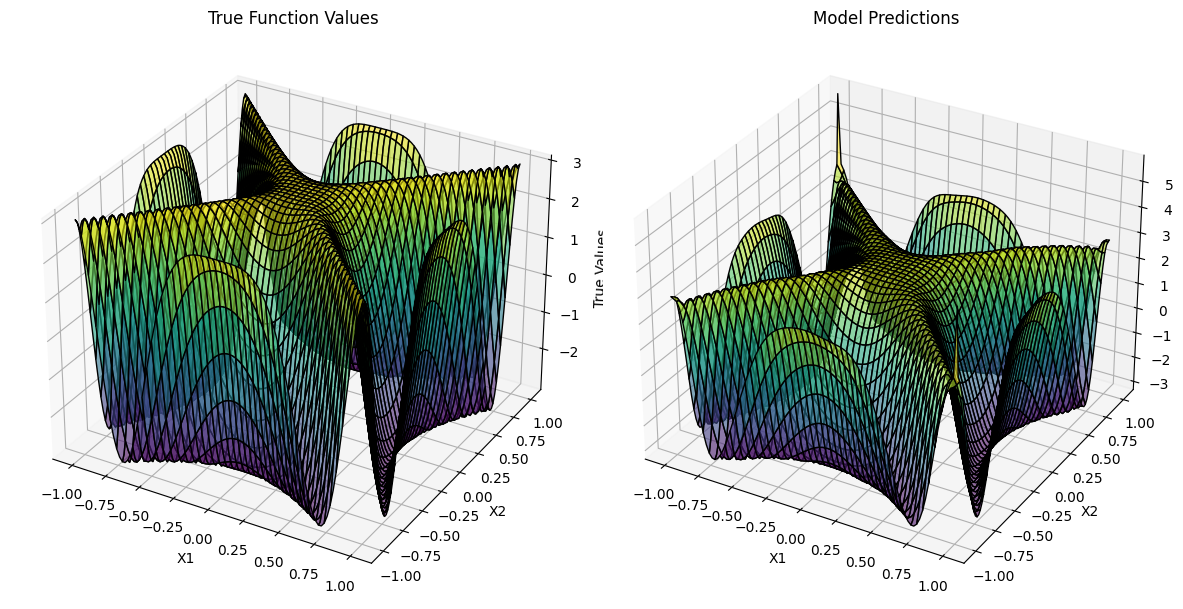

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Create a meshgrid for x1 and x2 values
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1, X2 = np.meshgrid(x1, x2)

# Compute y values for each pair of (x1, x2)
y_values = f(X1, X2)


# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()

y_pred = modelN4.predict(X)


from mpl_toolkits.mplot3d import Axes3D
# Reshape y_pred to match the shape of X1 and X2
y_pred_reshaped = y_pred.reshape(X1.shape)

# Plotting
fig = plt.figure(figsize=(12, 6))

# Plot True Values
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1, X2, y_values, cmap='viridis', edgecolor='k', alpha=0.6)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('True Values')
ax1.set_title('True Function Values')

# Plot Predicted Values
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1, X2, y_pred_reshaped, cmap='viridis', edgecolor='k', alpha=0.6)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Predicted Values')
ax2.set_title('Model Predictions')

plt.tight_layout()
plt.show()

In [ ]:
# Define the input values
x1_value = 1
x2_value = 0.7

# Create a numpy array with the input values
single_input = np.array([[x1_value, x2_value]])

# Use the model to make a prediction
prediction = modelN4.predict(single_input)
real = f(x1_value, x2_value)


# Print the prediction
print(f"The prediction for x1 = {x1_value} and x2 = {x2_value} is: {prediction[0][0]}")
print(f"The Real value for x1 = {x1_value} and x2 = {x2_value} is: {real}")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1.4251e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))    

import numpy as np
lower_bound = -1
upper_bound = 1
n_samples = 10000

x = np.random.uniform(lower_bound, upper_bound, size=(n_samples,1))
X = np.hstack((x, x))

y = 3 * np.cos(2 * np.pi * (X[:, 0]**2 - X[:, 1]**2)).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming H1Layer, H2Layer, H3Layer, H4Layer, H5Layer, and TensorDecompositionLayer are pre-defined
def build_model(input_shape, filters):
    rank = 4
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)

    # Using 'he_normal' initialization for the Dense layers
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = h2(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1, kernel_initializer='he_normal')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 128
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 128
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")
